<a href="https://colab.research.google.com/github/ownit4137/TIL/blob/main/DL%20from%20Scratch/2/210125_statistical_based_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive 
drive.mount('/content/gdrive/')

%cd /content/gdrive/MyDrive/'Colab Notebooks'/

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks


In [18]:
import numpy as np
import matplotlib.pyplot as plt

# 자연어 처리

- 사람의 말을 컴퓨터가 이해하도록 만드는 것
- 질의응답 시스템, IME, 문장 자동 요약, 감정분석 등에 사용됨
- 자연어 처리의 기초적인 단계인 단어 의미 파악에는 thesaurus, 통계 기반 기법, 추론 기반 기법 등이 있음

## Thesaurus(유의어 사전)

- 사람이 직접 단어의 의미를 미리 정해 놓음
- 모든 단어에 대해 유의어 집합을 만든 다음에, 단어의 관계를 그래프로 표현
- 가장 유명한 thesaurus중 하나는 **WordNet**, 방대한 단어 네트워크가 존재함
- 시대의 변화에 대응하기 어렵고, thesaurus를 만드는데 비용이 많이 듦, 단어간의 미묘한 차이를 표현할 수 없음

## 통계 기반

- corpus(말뭉치: 대량의 텍스트 데이터)를 분석하여 의미를 추출하는 것
- **distributional hypothesis**(분포 가설: 단어의 의미는 주변 단어에 의해 형성됨)에 따라 단어를 벡터로 표현함



In [2]:
def preprocess(text):
  text = text.lower()
  text = text.replace('.', ' .')
  words = text.split(' ')

  word_to_id = {}
  id_to_word = {}
  for word in words:
    if word not in word_to_id:
      new_id = len(word_to_id)
      word_to_id[word] = new_id
      id_to_word[new_id] = word

  corpus = np.array([word_to_id[w] for w in words])
  return corpus, word_to_id, id_to_word

In [5]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(word_to_id)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}


- 맥락(특정 단어를 중심으로 할 때 그 주변 단어들)을 기록함, 윈도우 크기에 따른 맥락을 결정
- 맥락은 단어들을 벡터로 표현하여 나타낼 수 있음
- 모든 단어에 대해 맥락을 기록한 것이 **co-occurance matrix**(동시발생 행렬)

In [6]:
def create_co_matrix(corpus, vocab_size, window_size=1):
  corpus_size = len(corpus)
  co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

  for idx, word_id in enumerate(corpus):
    for i in range(1, window_size + 1):
      left = idx - i
      right = idx + i

      if left >= 0:
        left_word_id = corpus[left]
        co_matrix[word_id, left_word_id] += 1

      if right < corpus_size:
        right_word_id = corpus[right]
        co_matrix[word_id, right_word_id] += 1
    
  return co_matrix

co_matrix = create_co_matrix(corpus, len(word_to_id))
print(co_matrix)

[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]


- 단어 벡터가 구해졌으므로(co-occurance matrix의 row), 벡터 간 유사도를 표현할 수 있음
- 대표적인 유사도 표현은 코사인 유사도(벡터 사잇각)
- similarity(x, y) = $\cfrac{x \cdot y}{  \| x \|  \| y \|  } $
- 분모는 L2 norm(the length of a vector in Euclidean space)


In [7]:
def cos_similarity(x, y, eps=1e-8):
  nx = x / np.sqrt(np.sum(x**2 + eps))  # DivideByZero Error
  ny = y / np.sqrt(np.sum(y**2 + eps))
  return np.dot(nx, ny)

c0 = co_matrix[word_to_id['you']]
c1 = co_matrix[word_to_id['i']]
print(cos_similarity(c0, c1))

0.7071067440634439


In [36]:
def most_similar(query, wti, itw, word_matrix):
  print(query)
  query_id = wti[query]
  query_vec = word_matrix[query_id]

  vocab_size = len(itw)
  similarity = np.zeros(vocab_size)
  for i in range(vocab_size):
    similarity[i] = cos_similarity(word_matrix[i], query_vec)

  for count in range(5):
    for i in (-1 * similarity).argsort():   # 내림차순(-1이 곱해짐) 정렬 후 인덱스 반환
      if itw[id] == query:
        continue
      print(itw[i], similarity[i])
  print()

- 단순 출현 빈도로만 분석한다면 결론이 잘못 도출될 수 있음
  - 말뭉치에서 the와 car은 높은 확률로 동시에 출현하므로 the와 car는 관계가 깊다 (x)
- 이를 해결하기 위해 점별 상호정보량(Pointwise Mutual Info)를 사용
- PMI(x, y) = $\log_2 \cfrac{P(x, y)}{  P(x)P(y)  } = \log_2 \cfrac{C(x, y) \cdot N}{  C(x)C(y)  } $
- $P(x)$ 는 $x$가 일어날 확률($C(x) / N$), $P(x, y)$는 $x$와 $y$가 동시에 일어날 확률 -> **단독으로 출현하는 횟수를 고려해줌**
- 코드에서는 양의 상호정보량(PPMI = max(0, PMI))을 사용 

In [42]:
def ppmi(co_matrix, verbose=False, eps=1e-8):
  ppmi_mat = np.zeros_like(co_matrix, dtype=np.float32)
  N = np.sum(co_matrix) # 총합 axis=0, 1
  C = np.sum(co_matrix, axis=0) # 단어별 합 axis=0

  for i in range(co_matrix.shape[0]):
    for j in range(co_matrix.shape[1]):
      pmi = np.log2((co_matrix[i, j] * N ) / (C[i] * C[j]) + eps)
      ppmi_mat[i, j] = max(0, pmi)

  return ppmi_mat

ppmi_matrix = ppmi(co_matrix)
print(ppmi_matrix)

[[0.   1.81 0.   0.   0.   0.   0.  ]
 [1.81 0.   0.81 0.   0.81 0.81 0.  ]
 [0.   0.81 0.   1.81 0.   0.   0.  ]
 [0.   0.   1.81 0.   1.81 0.   0.  ]
 [0.   0.81 0.   1.81 0.   0.   0.  ]
 [0.   0.81 0.   0.   0.   0.   2.81]
 [0.   0.   0.   0.   0.   2.81 0.  ]]


- PPMI 행렬은 corpus가 커질수록 matrix의 차원이 커지고 대부분의 원소가 0이라 비효율적임

## 차원 감소(Dimensionality Reduction)

- 벡터의 차원을 줄이는데, 데이터의 분포를 고려해 중요한 축을 찾는 것

### SVD(Singular Value Decomposition, 특잇값분해)

$X = USV^T$

- 임의의 행렬을 U, S, V로 분해(U와 V는 직교행렬, S는 대각행렬-해당 축의 중요도를 나타내는 특잇값이 나열되어 있음)
- S에서 특잇값이 높은 성분을 기준으로 U를 깎아냄(차원 감소)
- O(N^3)이므로 Truncated SVD를 많이 사용

In [17]:
U, S, V = np.linalg.svd(ppmi_matrix)

np.set_printoptions(precision=2)

print(U)
print()
print(S)
print()
print(V)

[[ 0.00e+00  3.41e-01 -3.89e-16 -1.21e-01 -1.11e-16 -9.32e-01 -1.09e-16]
 [-5.98e-01  0.00e+00  1.80e-01  0.00e+00 -7.81e-01  0.00e+00  0.00e+00]
 [-5.55e-17  4.36e-01 -2.22e-16 -5.09e-01 -1.39e-17  2.25e-01 -7.07e-01]
 [-4.98e-01  1.91e-16  6.80e-01 -6.27e-17  5.38e-01 -1.29e-16  8.58e-18]
 [-3.23e-17  4.36e-01 -1.65e-16 -5.09e-01 -1.35e-17  2.25e-01  7.07e-01]
 [-3.23e-17  7.09e-01 -1.65e-16  6.84e-01 -1.35e-17  1.71e-01  7.69e-17]
 [-6.28e-01 -2.96e-16 -7.10e-01  8.90e-17  3.17e-01  2.49e-16 -1.10e-17]]

[3.17e+00 3.17e+00 2.70e+00 2.70e+00 1.51e+00 1.51e+00 2.56e-17]

[[-3.41e-01 -1.11e-16 -4.36e-01  0.00e+00 -4.36e-01 -7.09e-01 -0.00e+00]
 [-0.00e+00  5.98e-01  1.32e-16  4.98e-01  1.87e-16 -2.01e-16  6.28e-01]
 [ 1.21e-01 -5.55e-16  5.09e-01  0.00e+00  5.09e-01 -6.84e-01 -0.00e+00]
 [ 0.00e+00 -1.80e-01 -5.60e-17 -6.80e-01 -5.60e-17  5.50e-17  7.10e-01]
 [-9.32e-01 -5.55e-17  2.25e-01  0.00e+00  2.25e-01  1.71e-01 -0.00e+00]
 [ 0.00e+00 -7.81e-01 -3.22e-16  5.38e-01 -2.11e-16  2.8

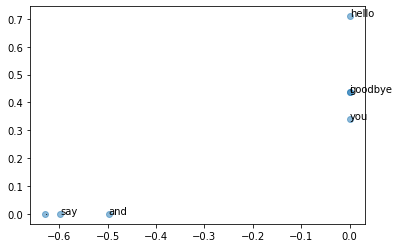

In [26]:
for word, word_id in word_to_id.items():
  plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

### PTB Dataset

- 대표적인 전처리된 corpus
- Truncated SVD를 이용하여 몇 가지 단어(querys)에 대해 유사 단어를 표시

In [35]:
from dataset import ptb

ptb_corpus, ptb_wti, ptb_itw = ptb.load_data('train')
print("corpus length", len(ptb_corpus))

print(ptb_itw[10])
print(ptb_wti['car'])

corpus length 929589
ipo
3856


In [ ]:
from sklearn.utils.extmath import randomized_svd

window_size = 2
wordvec_size = 100
vocab_size = len(ptb_wti)

ptb_co_matrix = create_co_matrix(corpus, vocab_size, window_size)

print("ptb_co_matrix shape : ", ptb_co_matrix.shape)

ptb_ppmi = ppmi(ptb_co_matrix)

print("ptb_ppmi shape : ", ptb_ppmi.shape)

ptb_U, ptb_S, ptb_V = randomized_svd(ptb_ppmi, n_components=wordvec_size, n_iter=5, random_state=None)

print("ptb_ppmi U matrix shape", ptb_U.shape)

word_vecs = ptb_U[:, wordvec_size]
querys = ['you', 'year', 'car', 'toyota']

for q in querys:
  most_similar(q, ptb_wti, ptb_itw, word_vecs)